In [1]:
%autosave 0
import numpy as np
import pandas as pd

Autosave disabled


# <center>Data Overview</center>

In [2]:
# https://www.kaggle.com/datasets/mukeshmanral/univariate-time-series
ts = pd.read_csv('date_count.csv')

In [3]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    578 non-null    object
 1   count   578 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.2+ KB


In [4]:
ts

,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2
...,...,...
573,2014-03-21,149
574,2014-03-22,129
575,2014-03-23,119
576,2014-03-24,214


### Preprocessing

In [5]:
ts['Date'] = pd.to_datetime(ts['Date'])
ts.set_index('Date', inplace=True)

### Time series plot

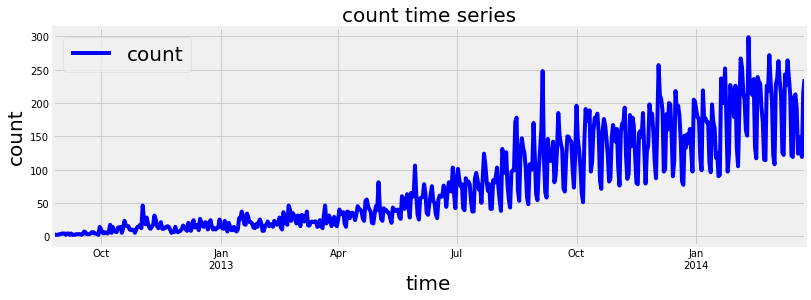

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

ts.plot(color='blue')
plt.title('count time series', size=20)
plt.xlabel('time', size=20)
plt.ylabel('count', size = 20)
plt.gcf().set_size_inches(12, 4)
plt.legend(loc=2, prop={'size': 20})

### Time series decomposition

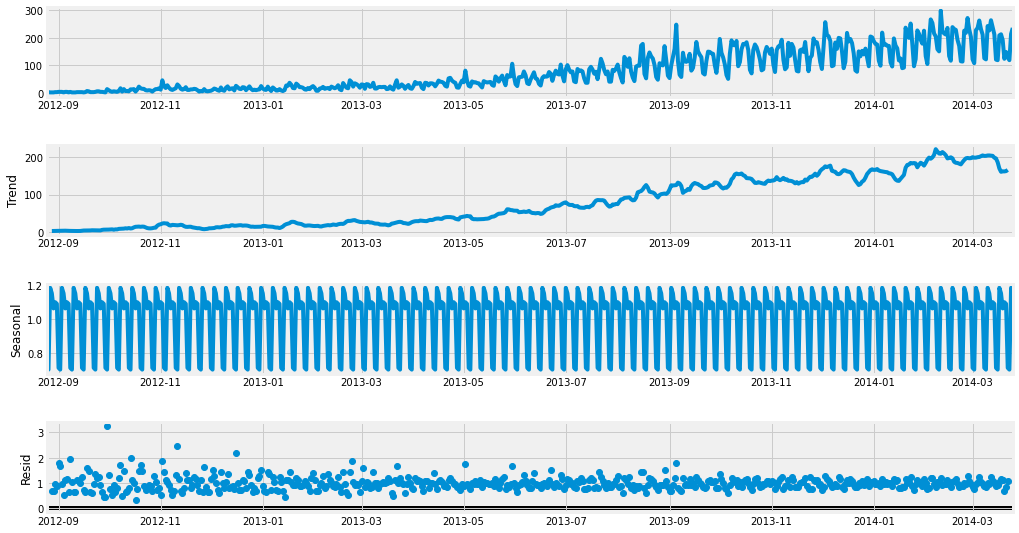

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts.asfreq('D')
decompose = seasonal_decompose(ts, model='multiplicative')
decompose.plot()
plt.gcf().set_size_inches(16, 8)
plt.show()

Let's have a closer look at the seasonality.

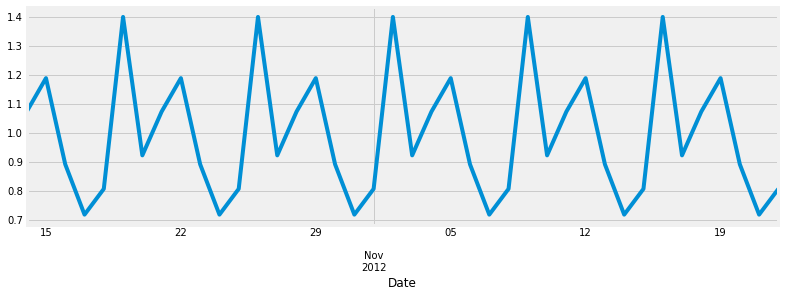

In [8]:
magified_seasonality = ts.iloc[50:90]
magified_seasonality.asfreq('D')
decomp = seasonal_decompose(magified_seasonality, model='multiplicative')
decomp.seasonal.plot()
plt.gcf().set_size_inches(12, 4)
plt.show()

It is now evident that weekly seasonality is present.

# <center>Multi-step 60-day forecast (fh = 60)</center>

### Train / test split

In [9]:
y_train = ts.iloc[:len(ts)-60]
y_test = ts.iloc[len(ts)-60:]

### Data preparation

In [10]:
from kats.consts import TimeSeriesData

y_train.reset_index(inplace=True)
y_train.columns = ["time", "value"]
y_train = TimeSeriesData(y_train)

### Training

Three models will be checked: HoltWintersModel, ThetaModel, STLFModel.

In [11]:
from kats.consts import SearchMethodEnum
from kats.models.holtwinters import HoltWintersModel, HoltWintersParams
from kats.models.stlf import STLFModel, STLFParams
from kats.models.theta import ThetaModel, ThetaParams
from kats.tsfeatures.tsfeatures import TsFeatures
from kats.models.metalearner.get_metadata import GetMetaData
import warnings                                 
warnings.filterwarnings('ignore')

MD = GetMetaData(
    all_models={
        "holtwinters": HoltWintersModel,
        "theta": ThetaModel,
        "stlf": STLFModel,
    },
    all_params={
        "holtwinters": HoltWintersParams,
        "theta": ThetaParams,
        "stlf": STLFParams,
    },
    data=y_train,
    error_method='mape',
    )

y_train_metadata = MD.get_meta_data()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [12]:
print(y_train_metadata['best_model'])
print(y_train_metadata['hpt_res'][y_train_metadata['best_model']])

holtwinters
({'damped': True, 'seasonal_periods': 7, 'trend': 'additive', 'seasonal': 'multiplicative'}, 0.16075832670454737)


### Forecasting with the best model

In [14]:
params = HoltWintersParams(
            trend="add",
            damped=True,
            seasonal="mul",
            seasonal_periods=7,
        )
m = HoltWintersModel(
    data=y_train, 
    params=params)

m.fit()
fcst = m.predict(steps=60, alpha = 0.1)

In [15]:
fcst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 518 to 577
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        60 non-null     datetime64[ns]
 1   fcst        60 non-null     float64       
 2   fcst_lower  60 non-null     float64       
 3   fcst_upper  60 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.0 KB


### Evaluation

In [16]:
fcst.set_index('time', inplace=True)
evaluation_df = fcst.assign(y_test=y_test['count'])

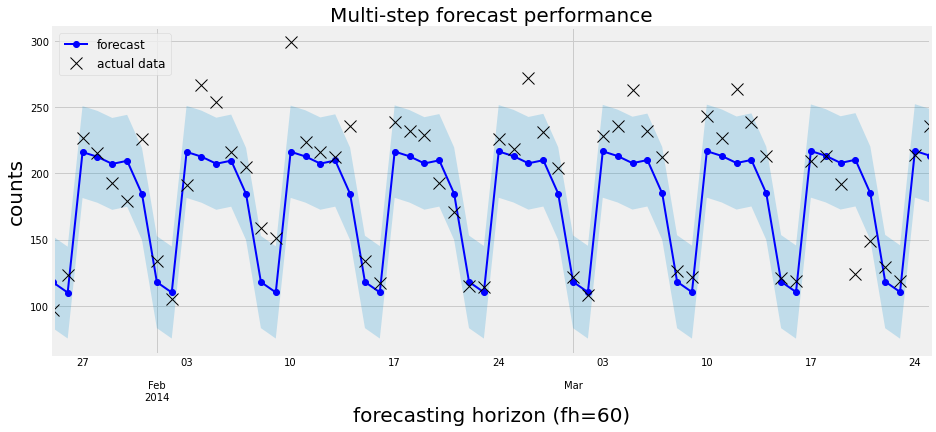

In [17]:
evaluation_df['fcst'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.fill_between(evaluation_df.index, evaluation_df['fcst_lower'], evaluation_df['fcst_upper'], alpha=0.2)
plt.title('Multi-step forecast performance', size=20)
plt.xlabel('forecasting horizon (fh=60)', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=2, prop={'size': 12})

In [18]:
def evaluation_metrics(y_test, y_pred, model_name):
    MAPE = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
    RMSE = np.mean((y_pred - y_test)**2)**.5  
    MAE = np.mean(np.abs(y_test - y_pred))
    return({'Model':model_name, 'MAPE':round(MAPE,3), 'RMSE':round(RMSE,3), 'MAE':round(MAE,3)})

accuracy = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'], 'HoltWinters')
print(accuracy)

{'Model': 'HoltWinters', 'MAPE': 11.269, 'RMSE': 29.178, 'MAE': 21.833}


In [19]:
performance_summary_fh60 = pd.read_csv('performance_summary_fh60.csv')
performance_summary_fh60 = performance_summary_fh60.append(accuracy, ignore_index=True)
performance_summary_fh60.to_csv('performance_summary_fh60.csv', index=False)

# <center>Rolling 1-day forecasting (fh=1)</center>

In [20]:
ts.reset_index(inplace=True)
ts.columns = ['time','value']
count_ts = TimeSeriesData(ts)

### Training / Forecasting

In this setup, training and forecasting is conducted one after another while the training data grows successively by 1 day.

In [21]:
evaluation_df = pd.DataFrame()
split = len(count_ts)-60

while split < len(count_ts):
    params = HoltWintersParams(
            trend="add",
            damped=True,
            seasonal="mul",
            seasonal_periods=7,
            )

    m = HoltWintersModel(data=count_ts[:split], params=params)
    m.fit()

    fcst = m.predict(
        steps=1, 
        freq="D"
        )
    evaluation_df = evaluation_df.append(fcst, ignore_index=True)
    split += 1

### Evaluation

In [22]:
evaluation_df.set_index('time', inplace=True)
evaluation_df = evaluation_df.assign(y_test=y_test['count'])

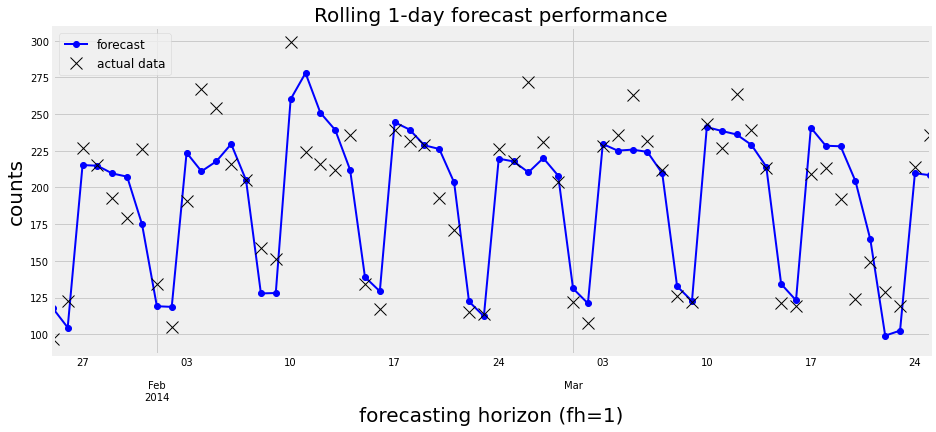

In [23]:
evaluation_df['fcst'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.title('Rolling 1-day forecast performance', size=20)
plt.xlabel('forecasting horizon (fh=1)', size=20)
plt.ylabel('counts', size = 20)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=2, prop={'size': 12})

In [24]:
accuracy = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'], 'HoltWinters')
print(accuracy)

{'Model': 'HoltWinters', 'MAPE': 10.512, 'RMSE': 25.775, 'MAE': 19.201}


In [25]:
performance_summary_fh1 = pd.read_csv('performance_summary_fh1.csv')
performance_summary_fh1 = performance_summary_fh1.append(accuracy, ignore_index=True)
performance_summary_fh1.to_csv('performance_summary_fh1.csv', index=False)